In [1]:
import numpy as np
import cv2
from scipy import ndimage
import matplotlib.pyplot as plt
from numpy import arctan2, fliplr, flipud
from keras.datasets import cifar10

Using TensorFlow backend.


In [2]:
!ls

1~				      mnist_vgg_2d~
1804.11191.pdf			      new.html~
2~				      newscred.py~
3~				      numta
4~				      others
client.py~			      pipeline~
compVision.py~			      prac
cv-algo				      python.png
deeplearningbook.pdf		      requirements~
directory~			      resume
draft.pdf			      server_echo.py~
first.py~			      server.py~
HOG_scratch.ipynb		      steps~
IAEA.zip			      test.py~
kaggle.json			      The Hisory Began from AlexNet.pdf
malaria_inference		      training01
Mathematics for Computer Science.pdf  Untitled Document~
mnist_data.csv			      yolo
mnist_vgg_2b~			      yolo.zip
mnist_vgg_2c~


In [3]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [4]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((50000, 32, 32, 3), (50000, 1), (10000, 32, 32, 3), (10000, 1))

In [5]:
def rgb2gray(rgb):

    r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b

    return gray

In [6]:
x_train_grey = []
x_test_grey = []

In [7]:
len(x_train[:1000])

1000

In [8]:
len(x_train[:1000, :])

1000

In [9]:
for i in x_train[:1000, :]:
    img = rgb2gray(i)
    x_train_grey.append(img)
x_train_grey = np.array(x_train_grey)

for j in x_test[:1000, :]:
    img = rgb2gray(j)
    x_test_grey.append(img)
x_test_grey = np.array(x_test_grey)

In [10]:
x_train_grey[0].shape

(32, 32)

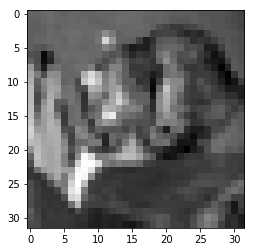

In [11]:
plt.imshow(x_test_grey[0], cmap=plt.cm.gray)

In [12]:
def pad_image_for_square( img ):
    (rows, cols, dim) = img.shape
    resize_dim = max( rows, cols)
    pad_row = resize_dim - rows
    pad_col = resize_dim - cols
    img = np.pad(img, ((0,pad_row), (0, pad_col), (0,0)), 'constant', constant_values=0)
    return img

In [13]:
def gradient(image):
  
    k_y = np.array([[-1,0,1]])
    k_x = np.array([[-1], [0], [1]])
    
    gx = ndimage.convolve(image, k_x, mode='constant', cval=1.0)
    gy = ndimage.convolve(image, k_y, mode='constant', cval=1.0)
    
    return gx, gy

In [14]:
def magnitude_and_theta(gx,gy):
    
    magnitude = np.sqrt(gx**2 + gy**2)
    magnitude = magnitude.astype(int)
    
    theta = (arctan2(gy, gx) * 180 / np.pi) % 360
    theta = theta.astype(int)
    
    return magnitude, theta

In [15]:
def calculateDistance(image1, image2):
    return np.sqrt(np.sum((image1-image2)**2)) 

In [16]:
def cell_histogram(cell_direction, cell_magnitude, hist_bins):
    cell_hist = np.zeros(shape=(hist_bins.size))
    cell_size = cell_direction.shape[0]
    
    for row_idx in range(cell_size):
        for col_idx in range(cell_size):
            curr_direction = cell_direction[row_idx, col_idx]
            curr_magnitude = cell_magnitude[row_idx, col_idx]
            diff = np.abs(curr_direction - hist_bins)
            min_idx = np.argmin(diff) #return minimum difference
            min_2nd =  np.argmin(np.partition(diff,1)[1])
            
            if diff[min_idx] == 0:
                cell_hist[min_idx] += curr_magnitude
            
            else:
               #linear interpolation
                diff_1 =  np.abs(curr_direction - hist_bins[min_idx])
                diff_2 =  np.abs(curr_direction - hist_bins[min_2nd])
                cell_hist[min_idx] += (diff_1/(diff_1+diff_2)) * curr_magnitude 
                cell_hist[min_2nd] += (diff_2/(diff_1+diff_2)) * curr_magnitude 
                
    cell_hist = np.array(cell_hist)
                
    return cell_hist 

In [17]:
hist_bins = np.array([0,20,40,60,80,100,120,140,160])

In [18]:
def normalized_histogram(m,theta):

    concat_hist = []
    cell_direction = theta[:8, :8]
    cell_magnitude = m[:8, :8]

    hist = cell_histogram(cell_direction,cell_magnitude,hist_bins)
    concat_hist.append(hist)

    cell_direction = m[:8, 8:16]
    cell_magnitude = theta[:8, 8:16]

    hist = cell_histogram(cell_direction,cell_magnitude,hist_bins)
    concat_hist.append(hist)

    cell_direction = m[8:16, :8]
    cell_magnitude = theta[8:16, :8]
    hist = cell_histogram(cell_direction,cell_magnitude,hist_bins)
    concat_hist.append(hist)

    cell_direction = m[8:16, 8:16]
    cell_magnitude = theta[8:16, 8:16]
    hist = cell_histogram(cell_direction,cell_magnitude,hist_bins)
    concat_hist.append(hist)
    concat_hist = np.array(concat_hist)
    concat_hist = concat_hist - np.mean(concat_hist) / np.std(concat_hist)

    return concat_hist
  
#normalize histogram

In [19]:
def sliding_window(image, step, window):
  
    x_loc = []
    y_loc = []
    cells = []

    for y in range(0, image.shape[0], step):
        for x in range(0, image.shape[1], step):
            cells.append(image[y:y + window[1], x:x + window[0]])
            x_loc.append(x)
            y_loc.append(y)
    return x_loc, y_loc, cells

In [42]:
concat_hist = []
concat_train_hist = []

In [43]:
for t in x_train_grey:
    #import pdb; pdb.set_trace()
    gx, gy = gradient(t)
    m, theta = magnitude_and_theta(gx,gy)
        
    (w, h) = 16, 16
    x_pos, y_pos, cells = sliding_window(m, 16, (w, h))
        

    for (x, y, cell) in zip(x_pos, y_pos, cells):
            cell_dir = cell
            cell_theta = theta[y:y + h, x:x + w]
            cell_magnitute = m[y:y + h, x:x + w]
    #print(cell_dir.shape, cell_theta.shape)
            hist = None
            hist = normalized_histogram(cell_magnitute,cell_theta)
            print(hist.shape)
            concat_hist.append(np.array(hist).ravel())
            
    print(np.array(concat_hist).shape)
    concat_train_hist.append(np.array(concat_hist))   
    concat_hist = []
    

(4, 9)
(4, 9)
(4, 9)
(4, 9)
(4, 36)
(4, 9)
(4, 9)
(4, 9)
(4, 9)
(4, 36)
(4, 9)
(4, 9)
(4, 9)
(4, 9)
(4, 36)
(4, 9)
(4, 9)
(4, 9)
(4, 9)
(4, 36)
(4, 9)
(4, 9)
(4, 9)
(4, 9)
(4, 36)
(4, 9)
(4, 9)
(4, 9)
(4, 9)
(4, 36)
(4, 9)
(4, 9)
(4, 9)
(4, 9)
(4, 36)
(4, 9)
(4, 9)
(4, 9)
(4, 9)
(4, 36)
(4, 9)
(4, 9)
(4, 9)
(4, 9)
(4, 36)
(4, 9)
(4, 9)
(4, 9)
(4, 9)
(4, 36)
(4, 9)
(4, 9)
(4, 9)
(4, 9)
(4, 36)
(4, 9)
(4, 9)
(4, 9)
(4, 9)
(4, 36)
(4, 9)
(4, 9)
(4, 9)
(4, 9)
(4, 36)
(4, 9)
(4, 9)
(4, 9)
(4, 9)
(4, 36)
(4, 9)
(4, 9)
(4, 9)
(4, 9)
(4, 36)
(4, 9)
(4, 9)
(4, 9)
(4, 9)
(4, 36)
(4, 9)
(4, 9)
(4, 9)
(4, 9)
(4, 36)
(4, 9)
(4, 9)
(4, 9)
(4, 9)
(4, 36)
(4, 9)
(4, 9)
(4, 9)
(4, 9)
(4, 36)
(4, 9)
(4, 9)
(4, 9)
(4, 9)
(4, 36)
(4, 9)
(4, 9)
(4, 9)
(4, 9)
(4, 36)
(4, 9)
(4, 9)
(4, 9)
(4, 9)
(4, 36)
(4, 9)
(4, 9)
(4, 9)
(4, 9)
(4, 36)
(4, 9)
(4, 9)
(4, 9)
(4, 9)
(4, 36)
(4, 9)
(4, 9)
(4, 9)
(4, 9)
(4, 36)
(4, 9)
(4, 9)
(4, 9)
(4, 9)
(4, 36)
(4, 9)
(4, 9)
(4, 9)
(4, 9)
(4, 36)
(4, 9)
(4, 9)
(4, 9)
(4, 9)


(4, 9)
(4, 9)
(4, 9)
(4, 36)
(4, 9)
(4, 9)
(4, 9)
(4, 9)
(4, 36)
(4, 9)
(4, 9)
(4, 9)
(4, 9)
(4, 36)
(4, 9)
(4, 9)
(4, 9)
(4, 9)
(4, 36)
(4, 9)
(4, 9)
(4, 9)
(4, 9)
(4, 36)
(4, 9)
(4, 9)
(4, 9)
(4, 9)
(4, 36)
(4, 9)
(4, 9)
(4, 9)
(4, 9)
(4, 36)
(4, 9)
(4, 9)
(4, 9)
(4, 9)
(4, 36)
(4, 9)
(4, 9)
(4, 9)
(4, 9)
(4, 36)
(4, 9)
(4, 9)
(4, 9)
(4, 9)
(4, 36)
(4, 9)
(4, 9)
(4, 9)
(4, 9)
(4, 36)
(4, 9)
(4, 9)
(4, 9)
(4, 9)
(4, 36)
(4, 9)
(4, 9)
(4, 9)
(4, 9)
(4, 36)
(4, 9)
(4, 9)
(4, 9)
(4, 9)
(4, 36)
(4, 9)
(4, 9)
(4, 9)
(4, 9)
(4, 36)
(4, 9)
(4, 9)
(4, 9)
(4, 9)
(4, 36)
(4, 9)
(4, 9)
(4, 9)
(4, 9)
(4, 36)
(4, 9)
(4, 9)
(4, 9)
(4, 9)
(4, 36)
(4, 9)
(4, 9)
(4, 9)
(4, 9)
(4, 36)
(4, 9)
(4, 9)
(4, 9)
(4, 9)
(4, 36)
(4, 9)
(4, 9)
(4, 9)
(4, 9)
(4, 36)
(4, 9)
(4, 9)
(4, 9)
(4, 9)
(4, 36)
(4, 9)
(4, 9)
(4, 9)
(4, 9)
(4, 36)
(4, 9)
(4, 9)
(4, 9)
(4, 9)
(4, 36)
(4, 9)
(4, 9)
(4, 9)
(4, 9)
(4, 36)
(4, 9)
(4, 9)
(4, 9)
(4, 9)
(4, 36)
(4, 9)
(4, 9)
(4, 9)
(4, 9)
(4, 36)
(4, 9)
(4, 9)
(4, 9)
(4, 9)
(4, 36)

(4, 9)
(4, 9)
(4, 36)
(4, 9)
(4, 9)
(4, 9)
(4, 9)
(4, 36)
(4, 9)
(4, 9)
(4, 9)
(4, 9)
(4, 36)
(4, 9)
(4, 9)
(4, 9)
(4, 9)
(4, 36)
(4, 9)
(4, 9)
(4, 9)
(4, 9)
(4, 36)
(4, 9)
(4, 9)
(4, 9)
(4, 9)
(4, 36)
(4, 9)
(4, 9)
(4, 9)
(4, 9)
(4, 36)
(4, 9)
(4, 9)
(4, 9)
(4, 9)
(4, 36)
(4, 9)
(4, 9)
(4, 9)
(4, 9)
(4, 36)
(4, 9)
(4, 9)
(4, 9)
(4, 9)
(4, 36)
(4, 9)
(4, 9)
(4, 9)
(4, 9)
(4, 36)
(4, 9)
(4, 9)
(4, 9)
(4, 9)
(4, 36)
(4, 9)
(4, 9)
(4, 9)
(4, 9)
(4, 36)
(4, 9)
(4, 9)
(4, 9)
(4, 9)
(4, 36)
(4, 9)
(4, 9)
(4, 9)
(4, 9)
(4, 36)
(4, 9)
(4, 9)
(4, 9)
(4, 9)
(4, 36)
(4, 9)
(4, 9)
(4, 9)
(4, 9)
(4, 36)
(4, 9)
(4, 9)
(4, 9)
(4, 9)
(4, 36)
(4, 9)
(4, 9)
(4, 9)
(4, 9)
(4, 36)
(4, 9)
(4, 9)
(4, 9)
(4, 9)
(4, 36)
(4, 9)
(4, 9)
(4, 9)
(4, 9)
(4, 36)
(4, 9)
(4, 9)
(4, 9)
(4, 9)
(4, 36)
(4, 9)
(4, 9)
(4, 9)
(4, 9)
(4, 36)
(4, 9)
(4, 9)
(4, 9)
(4, 9)
(4, 36)
(4, 9)
(4, 9)
(4, 9)
(4, 9)
(4, 36)
(4, 9)
(4, 9)
(4, 9)
(4, 9)
(4, 36)
(4, 9)
(4, 9)
(4, 9)
(4, 9)
(4, 36)
(4, 9)
(4, 9)
(4, 9)
(4, 9)
(4, 36)
(4, 9)

(4, 9)
(4, 36)
(4, 9)
(4, 9)
(4, 9)
(4, 9)
(4, 36)
(4, 9)
(4, 9)
(4, 9)
(4, 9)
(4, 36)
(4, 9)
(4, 9)
(4, 9)
(4, 9)
(4, 36)
(4, 9)
(4, 9)
(4, 9)
(4, 9)
(4, 36)
(4, 9)
(4, 9)
(4, 9)
(4, 9)
(4, 36)
(4, 9)
(4, 9)
(4, 9)
(4, 9)
(4, 36)
(4, 9)
(4, 9)
(4, 9)
(4, 9)
(4, 36)
(4, 9)
(4, 9)
(4, 9)
(4, 9)
(4, 36)
(4, 9)
(4, 9)
(4, 9)
(4, 9)
(4, 36)
(4, 9)
(4, 9)
(4, 9)
(4, 9)
(4, 36)
(4, 9)
(4, 9)
(4, 9)
(4, 9)
(4, 36)
(4, 9)
(4, 9)
(4, 9)
(4, 9)
(4, 36)
(4, 9)
(4, 9)
(4, 9)
(4, 9)
(4, 36)
(4, 9)
(4, 9)
(4, 9)
(4, 9)
(4, 36)
(4, 9)
(4, 9)
(4, 9)
(4, 9)
(4, 36)
(4, 9)
(4, 9)
(4, 9)
(4, 9)
(4, 36)
(4, 9)
(4, 9)
(4, 9)
(4, 9)
(4, 36)
(4, 9)
(4, 9)
(4, 9)
(4, 9)
(4, 36)
(4, 9)
(4, 9)
(4, 9)
(4, 9)
(4, 36)
(4, 9)
(4, 9)
(4, 9)
(4, 9)
(4, 36)
(4, 9)
(4, 9)
(4, 9)
(4, 9)
(4, 36)
(4, 9)
(4, 9)
(4, 9)
(4, 9)
(4, 36)
(4, 9)
(4, 9)
(4, 9)
(4, 9)
(4, 36)
(4, 9)
(4, 9)
(4, 9)
(4, 9)
(4, 36)
(4, 9)
(4, 9)
(4, 9)
(4, 9)
(4, 36)
(4, 9)
(4, 9)
(4, 9)
(4, 9)
(4, 36)
(4, 9)
(4, 9)
(4, 9)
(4, 9)
(4, 36)
(4, 9)
(4, 9)

(4, 9)
(4, 9)
(4, 9)
(4, 9)
(4, 36)
(4, 9)
(4, 9)
(4, 9)
(4, 9)
(4, 36)
(4, 9)
(4, 9)
(4, 9)
(4, 9)
(4, 36)
(4, 9)
(4, 9)
(4, 9)
(4, 9)
(4, 36)
(4, 9)
(4, 9)
(4, 9)
(4, 9)
(4, 36)
(4, 9)
(4, 9)
(4, 9)
(4, 9)
(4, 36)
(4, 9)
(4, 9)
(4, 9)
(4, 9)
(4, 36)
(4, 9)
(4, 9)
(4, 9)
(4, 9)
(4, 36)
(4, 9)
(4, 9)
(4, 9)
(4, 9)
(4, 36)
(4, 9)
(4, 9)
(4, 9)
(4, 9)
(4, 36)
(4, 9)
(4, 9)
(4, 9)
(4, 9)
(4, 36)
(4, 9)
(4, 9)
(4, 9)
(4, 9)
(4, 36)
(4, 9)
(4, 9)
(4, 9)
(4, 9)
(4, 36)
(4, 9)
(4, 9)
(4, 9)
(4, 9)
(4, 36)
(4, 9)
(4, 9)
(4, 9)
(4, 9)
(4, 36)
(4, 9)
(4, 9)
(4, 9)
(4, 9)
(4, 36)
(4, 9)
(4, 9)
(4, 9)
(4, 9)
(4, 36)
(4, 9)
(4, 9)
(4, 9)
(4, 9)
(4, 36)
(4, 9)
(4, 9)
(4, 9)
(4, 9)
(4, 36)
(4, 9)
(4, 9)
(4, 9)
(4, 9)
(4, 36)
(4, 9)
(4, 9)
(4, 9)
(4, 9)
(4, 36)
(4, 9)
(4, 9)
(4, 9)
(4, 9)
(4, 36)
(4, 9)
(4, 9)
(4, 9)
(4, 9)
(4, 36)
(4, 9)
(4, 9)
(4, 9)
(4, 9)
(4, 36)
(4, 9)
(4, 9)
(4, 9)
(4, 9)
(4, 36)
(4, 9)
(4, 9)
(4, 9)
(4, 9)
(4, 36)
(4, 9)
(4, 9)
(4, 9)
(4, 9)
(4, 36)
(4, 9)
(4, 9)
(4, 9)
(4, 9)


In [44]:
len(concat_train_hist)

1000

In [45]:
concat_train_hist[0].shape, concat_train_hist[900].shape

((4, 36), (4, 36))

In [48]:
concat_test_hist = []
concat_hist = []

In [49]:
for tst in x_test_grey:
    gx, gy = gradient(tst)
    m, theta = magnitude_and_theta(gx,gy)
        
    (w, h) = 16, 16
    x_pos, y_pos, cells = sliding_window(m, 16, (w, h))
        

    for (x, y, cell) in zip(x_pos, y_pos, cells):
            cell_dir = cell
            cell_theta = theta[y:y + h, x:x + w]
            cell_magnitute = m[y:y + h, x:x + w]
    #print(cell_dir.shape, cell_theta.shape)
            hist = None
            hist = normalized_histogram(cell_magnitute,cell_theta)
            print(hist.shape)
            concat_hist.append(np.array(hist).ravel())
    
    print(np.array(concat_hist).shape)
    concat_test_hist.append(np.array(concat_hist)) 
    concat_hist = []

(4, 9)
(4, 9)
(4, 9)
(4, 9)
(4, 36)
(4, 9)
(4, 9)
(4, 9)
(4, 9)
(4, 36)
(4, 9)
(4, 9)
(4, 9)
(4, 9)
(4, 36)
(4, 9)
(4, 9)
(4, 9)
(4, 9)
(4, 36)
(4, 9)
(4, 9)
(4, 9)
(4, 9)
(4, 36)
(4, 9)
(4, 9)
(4, 9)
(4, 9)
(4, 36)
(4, 9)
(4, 9)
(4, 9)
(4, 9)
(4, 36)
(4, 9)
(4, 9)
(4, 9)
(4, 9)
(4, 36)
(4, 9)
(4, 9)
(4, 9)
(4, 9)
(4, 36)
(4, 9)
(4, 9)
(4, 9)
(4, 9)
(4, 36)
(4, 9)
(4, 9)
(4, 9)
(4, 9)
(4, 36)
(4, 9)
(4, 9)
(4, 9)
(4, 9)
(4, 36)
(4, 9)
(4, 9)
(4, 9)
(4, 9)
(4, 36)
(4, 9)
(4, 9)
(4, 9)
(4, 9)
(4, 36)
(4, 9)
(4, 9)
(4, 9)
(4, 9)
(4, 36)
(4, 9)
(4, 9)
(4, 9)
(4, 9)
(4, 36)
(4, 9)
(4, 9)
(4, 9)
(4, 9)
(4, 36)
(4, 9)
(4, 9)
(4, 9)
(4, 9)
(4, 36)
(4, 9)
(4, 9)
(4, 9)
(4, 9)
(4, 36)
(4, 9)
(4, 9)
(4, 9)
(4, 9)
(4, 36)
(4, 9)
(4, 9)
(4, 9)
(4, 9)
(4, 36)
(4, 9)
(4, 9)
(4, 9)
(4, 9)
(4, 36)
(4, 9)
(4, 9)
(4, 9)
(4, 9)
(4, 36)
(4, 9)
(4, 9)
(4, 9)
(4, 9)
(4, 36)
(4, 9)
(4, 9)
(4, 9)
(4, 9)
(4, 36)
(4, 9)
(4, 9)
(4, 9)
(4, 9)
(4, 36)
(4, 9)
(4, 9)
(4, 9)
(4, 9)
(4, 36)
(4, 9)
(4, 9)
(4, 9)
(4, 9)


(4, 9)
(4, 9)
(4, 9)
(4, 36)
(4, 9)
(4, 9)
(4, 9)
(4, 9)
(4, 36)
(4, 9)
(4, 9)
(4, 9)
(4, 9)
(4, 36)
(4, 9)
(4, 9)
(4, 9)
(4, 9)
(4, 36)
(4, 9)
(4, 9)
(4, 9)
(4, 9)
(4, 36)
(4, 9)
(4, 9)
(4, 9)
(4, 9)
(4, 36)
(4, 9)
(4, 9)
(4, 9)
(4, 9)
(4, 36)
(4, 9)
(4, 9)
(4, 9)
(4, 9)
(4, 36)
(4, 9)
(4, 9)
(4, 9)
(4, 9)
(4, 36)
(4, 9)
(4, 9)
(4, 9)
(4, 9)
(4, 36)
(4, 9)
(4, 9)
(4, 9)
(4, 9)
(4, 36)
(4, 9)
(4, 9)
(4, 9)
(4, 9)
(4, 36)
(4, 9)
(4, 9)
(4, 9)
(4, 9)
(4, 36)
(4, 9)
(4, 9)
(4, 9)
(4, 9)
(4, 36)
(4, 9)
(4, 9)
(4, 9)
(4, 9)
(4, 36)
(4, 9)
(4, 9)
(4, 9)
(4, 9)
(4, 36)
(4, 9)
(4, 9)
(4, 9)
(4, 9)
(4, 36)
(4, 9)
(4, 9)
(4, 9)
(4, 9)
(4, 36)
(4, 9)
(4, 9)
(4, 9)
(4, 9)
(4, 36)
(4, 9)
(4, 9)
(4, 9)
(4, 9)
(4, 36)
(4, 9)
(4, 9)
(4, 9)
(4, 9)
(4, 36)
(4, 9)
(4, 9)
(4, 9)
(4, 9)
(4, 36)
(4, 9)
(4, 9)
(4, 9)
(4, 9)
(4, 36)
(4, 9)
(4, 9)
(4, 9)
(4, 9)
(4, 36)
(4, 9)
(4, 9)
(4, 9)
(4, 9)
(4, 36)
(4, 9)
(4, 9)
(4, 9)
(4, 9)
(4, 36)
(4, 9)
(4, 9)
(4, 9)
(4, 9)
(4, 36)
(4, 9)
(4, 9)
(4, 9)
(4, 9)
(4, 36)

(4, 9)
(4, 36)
(4, 9)
(4, 9)
(4, 9)
(4, 9)
(4, 36)
(4, 9)
(4, 9)
(4, 9)
(4, 9)
(4, 36)
(4, 9)
(4, 9)
(4, 9)
(4, 9)
(4, 36)
(4, 9)
(4, 9)
(4, 9)
(4, 9)
(4, 36)
(4, 9)
(4, 9)
(4, 9)
(4, 9)
(4, 36)
(4, 9)
(4, 9)
(4, 9)
(4, 9)
(4, 36)
(4, 9)
(4, 9)
(4, 9)
(4, 9)
(4, 36)
(4, 9)
(4, 9)
(4, 9)
(4, 9)
(4, 36)
(4, 9)
(4, 9)
(4, 9)
(4, 9)
(4, 36)
(4, 9)
(4, 9)
(4, 9)
(4, 9)
(4, 36)
(4, 9)
(4, 9)
(4, 9)
(4, 9)
(4, 36)
(4, 9)
(4, 9)
(4, 9)
(4, 9)
(4, 36)
(4, 9)
(4, 9)
(4, 9)
(4, 9)
(4, 36)
(4, 9)
(4, 9)
(4, 9)
(4, 9)
(4, 36)
(4, 9)
(4, 9)
(4, 9)
(4, 9)
(4, 36)
(4, 9)
(4, 9)
(4, 9)
(4, 9)
(4, 36)
(4, 9)
(4, 9)
(4, 9)
(4, 9)
(4, 36)
(4, 9)
(4, 9)
(4, 9)
(4, 9)
(4, 36)
(4, 9)
(4, 9)
(4, 9)
(4, 9)
(4, 36)
(4, 9)
(4, 9)
(4, 9)
(4, 9)
(4, 36)
(4, 9)
(4, 9)
(4, 9)
(4, 9)
(4, 36)
(4, 9)
(4, 9)
(4, 9)
(4, 9)
(4, 36)
(4, 9)
(4, 9)
(4, 9)
(4, 9)
(4, 36)
(4, 9)
(4, 9)
(4, 9)
(4, 9)
(4, 36)
(4, 9)
(4, 9)
(4, 9)
(4, 9)
(4, 36)
(4, 9)
(4, 9)
(4, 9)
(4, 9)
(4, 36)
(4, 9)
(4, 9)
(4, 9)
(4, 9)
(4, 36)
(4, 9)
(4, 9)

(4, 9)
(4, 9)
(4, 9)
(4, 36)
(4, 9)
(4, 9)
(4, 9)
(4, 9)
(4, 36)
(4, 9)
(4, 9)
(4, 9)
(4, 9)
(4, 36)
(4, 9)
(4, 9)
(4, 9)
(4, 9)
(4, 36)
(4, 9)
(4, 9)
(4, 9)
(4, 9)
(4, 36)
(4, 9)
(4, 9)
(4, 9)
(4, 9)
(4, 36)
(4, 9)
(4, 9)
(4, 9)
(4, 9)
(4, 36)
(4, 9)
(4, 9)
(4, 9)
(4, 9)
(4, 36)
(4, 9)
(4, 9)
(4, 9)
(4, 9)
(4, 36)
(4, 9)
(4, 9)
(4, 9)
(4, 9)
(4, 36)
(4, 9)
(4, 9)
(4, 9)
(4, 9)
(4, 36)
(4, 9)
(4, 9)
(4, 9)
(4, 9)
(4, 36)
(4, 9)
(4, 9)
(4, 9)
(4, 9)
(4, 36)
(4, 9)
(4, 9)
(4, 9)
(4, 9)
(4, 36)
(4, 9)
(4, 9)
(4, 9)
(4, 9)
(4, 36)
(4, 9)
(4, 9)
(4, 9)
(4, 9)
(4, 36)
(4, 9)
(4, 9)
(4, 9)
(4, 9)
(4, 36)
(4, 9)
(4, 9)
(4, 9)
(4, 9)
(4, 36)
(4, 9)
(4, 9)
(4, 9)
(4, 9)
(4, 36)
(4, 9)
(4, 9)
(4, 9)
(4, 9)
(4, 36)
(4, 9)
(4, 9)
(4, 9)
(4, 9)
(4, 36)
(4, 9)
(4, 9)
(4, 9)
(4, 9)
(4, 36)
(4, 9)
(4, 9)
(4, 9)
(4, 9)
(4, 36)
(4, 9)
(4, 9)
(4, 9)
(4, 9)
(4, 36)
(4, 9)
(4, 9)
(4, 9)
(4, 9)
(4, 36)
(4, 9)
(4, 9)
(4, 9)
(4, 9)
(4, 36)
(4, 9)
(4, 9)
(4, 9)
(4, 9)
(4, 36)
(4, 9)
(4, 9)
(4, 9)
(4, 9)
(4, 36)

(4, 9)
(4, 9)
(4, 9)
(4, 36)
(4, 9)
(4, 9)
(4, 9)
(4, 9)
(4, 36)
(4, 9)
(4, 9)
(4, 9)
(4, 9)
(4, 36)
(4, 9)
(4, 9)
(4, 9)
(4, 9)
(4, 36)
(4, 9)
(4, 9)
(4, 9)
(4, 9)
(4, 36)
(4, 9)
(4, 9)
(4, 9)
(4, 9)
(4, 36)
(4, 9)
(4, 9)
(4, 9)
(4, 9)
(4, 36)
(4, 9)
(4, 9)
(4, 9)
(4, 9)
(4, 36)
(4, 9)
(4, 9)
(4, 9)
(4, 9)
(4, 36)
(4, 9)
(4, 9)
(4, 9)
(4, 9)
(4, 36)
(4, 9)
(4, 9)
(4, 9)
(4, 9)
(4, 36)
(4, 9)
(4, 9)
(4, 9)
(4, 9)
(4, 36)
(4, 9)
(4, 9)
(4, 9)
(4, 9)
(4, 36)
(4, 9)
(4, 9)
(4, 9)
(4, 9)
(4, 36)
(4, 9)
(4, 9)
(4, 9)
(4, 9)
(4, 36)
(4, 9)
(4, 9)
(4, 9)
(4, 9)
(4, 36)
(4, 9)
(4, 9)
(4, 9)
(4, 9)
(4, 36)
(4, 9)
(4, 9)
(4, 9)
(4, 9)
(4, 36)
(4, 9)
(4, 9)
(4, 9)
(4, 9)
(4, 36)
(4, 9)
(4, 9)
(4, 9)
(4, 9)
(4, 36)
(4, 9)
(4, 9)
(4, 9)
(4, 9)
(4, 36)
(4, 9)
(4, 9)
(4, 9)
(4, 9)
(4, 36)
(4, 9)
(4, 9)
(4, 9)
(4, 9)
(4, 36)
(4, 9)
(4, 9)
(4, 9)
(4, 9)
(4, 36)
(4, 9)
(4, 9)
(4, 9)
(4, 9)
(4, 36)
(4, 9)
(4, 9)
(4, 9)
(4, 9)
(4, 36)
(4, 9)
(4, 9)
(4, 9)
(4, 9)
(4, 36)
(4, 9)
(4, 9)
(4, 9)
(4, 9)
(4, 36)

In [50]:
x_train_grey.shape, x_test_grey.shape

((1000, 32, 32), (1000, 32, 32))

In [51]:
test_hist = np.array(concat_test_hist)
train_hist = np.array(concat_train_hist)

len(test_hist), len(train_hist)

(1000, 1000)

In [52]:
test_hist[0].shape

(4, 36)

In [53]:
train_hist.shape, test_hist.shape

((1000, 4, 36), (1000, 4, 36))

In [54]:
train_hist[0].shape, test_hist[1].shape, test_hist[2].shape, test_hist[500].shape, test_hist[900].shape

((4, 36), (4, 36), (4, 36), (4, 36), (4, 36))

In [55]:
train_hist[0].shape, train_hist[1].shape, train_hist[500].shape, train_hist[900].shape

((4, 36), (4, 36), (4, 36), (4, 36))

In [56]:
len(test_hist[500])

4

In [57]:
train_hist[0].shape

(4, 36)

In [58]:
x = []
y = []

In [59]:
##Problem from here, tr er shape change hoye jay

In [61]:
for ts in test_hist:
    for tr in train_hist:
        #x = []
        x.append(calculateDistance(ts, tr))
        index_min = np.argmin(x)    
    x = []
    y.append(y_train[index_min])

In [64]:
len(y)

1000

In [65]:
y[0]

array([7], dtype=uint8)

In [66]:
y[1]

array([7], dtype=uint8)

In [67]:
y[55]

array([5], dtype=uint8)

In [69]:
y[900]

array([6], dtype=uint8)

In [62]:
ts.shape

(4, 36)

In [63]:
tr.shape

(4, 36)

In [0]:
def calculateDistance(image1, image2):
    return np.sqrt(np.sum((image1-image2)**2)) 

In [0]:
cell_theta.shape

(16, 8)

In [0]:
x_pos, y_pos, cells = sliding_window(m, 8, (w, h))

In [0]:
m.shape

(32, 32)

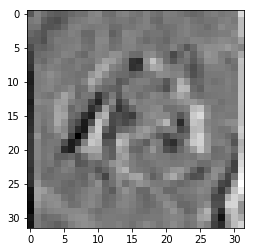

In [0]:
plt.imshow(gy,cmap=plt.cm.gray)
plt.savefig('frog_grey_y.jpg')

In [0]:
def magnitude_and_theta(gx,gy):
    
    magnitude = np.sqrt(gx**2 + gy**2)
    magnitude = magnitude.astype(int)
    theta = (arctan2(gy, gx) * 180 / np.pi) % 360
    theta = theta.astype(int)
    return magnitude, theta

In [0]:
m, theta = magnitude_and_theta(gx,gy)

NameError: name 'gx' is not defined

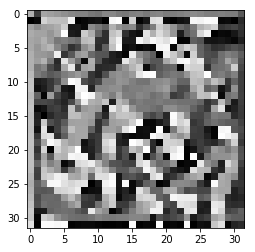

In [0]:
plt.imshow(theta,cmap=plt.cm.gray)
plt.savefig('frog_grey_theta.jpg')

In [0]:
cell_direction = m[:8, :8]
cell_magnitude = theta[:8, :8]

In [0]:
hist_bins = np.array([0,20,40,60,80,100,120,140,160])

In [0]:
def cell_histogram(cell_direction, cell_magnitude, hist_bins):
    cell_hist = np.zeros(shape=(hist_bins.size))
    cell_size = cell_direction.shape[0]
    
    for row_idx in range(cell_size):
        for col_idx in range(cell_size):
            curr_direction = cell_direction[row_idx, col_idx]
            curr_magnitude = cell_magnitude[row_idx, col_idx]
            diff = np.abs(curr_direction - hist_bins)
            min_idx = np.argmin(diff) #return minimum difference
            min_2nd =  np.argmin(np.partition(diff,1)[1])
            
            if diff[min_idx] == 0:
                cell_hist[min_idx] += curr_magnitude
            
            else:
               #linear interpolation
                diff_1 =  np.abs(curr_direction - hist_bins[min_idx])
                diff_2 =  np.abs(curr_direction - hist_bins[min_2nd])
                cell_hist[min_idx] += (diff_1/(diff_1+diff_2)) * curr_magnitude 
                cell_hist[min_2nd] += (diff_2/(diff_1+diff_2)) * curr_magnitude 
    cell_hist = np.array(cell_hist)
                
    return cell_hist 

In [0]:
cell_histogram(cell_direction, cell_magnitude, hist_bins)

array([12547.78624735,   586.24318182,   423.19203297,    28.04572947,
         111.08171769,   124.4555139 ,    58.69166667,    26.56428571,
         609.93962443])

In [0]:
def normalized_histogram(m,theta):

    concat_hist = []
    cell_direction = theta[:8, :8]
    cell_magnitude = m[:8, :8]

    hist = cell_histogram(cell_direction,cell_magnitude,hist_bins)
    concat_hist.append(hist)

    cell_direction = m[:8, 8:16]
    cell_magnitude = theta[:8, 8:16]

    hist = cell_histogram(cell_direction,cell_magnitude,hist_bins)
    concat_hist.append(hist)

    cell_direction = m[8:16, :8]
    cell_magnitude = theta[8:16, :8]
    hist = cell_histogram(cell_direction,cell_magnitude,hist_bins)
    concat_hist.append(hist)

    cell_direction = m[8:16, 8:16]
    cell_magnitude = theta[8:16, 8:16]
    hist = cell_histogram(cell_direction,cell_magnitude,hist_bins)
    concat_hist.append(hist)
    concat_hist = np.array(concat_hist)
    concat_hist = concat_hist - np.mean(concat_hist) / np.std(concat_hist)

    return concat_hist
#normalize histogram

In [0]:
len(normalized_histogram(m,theta))

4

In [0]:
def sliding_window(image, step, window):
    x_loc = []
    y_loc = []
    cells = []

    for y in range(0, image.shape[0], step):
        for x in range(0, image.shape[1], step):
            cells.append(image[y:y + window[1], x:x + window[0]])
            x_loc.append(x)
            y_loc.append(y)
    return x_loc, y_loc, cells

In [0]:
(w, h) = 16, 16

In [0]:
x_pos, y_pos, cells = sliding_window(m, 8, (w, h))
len(x_pos), len(y_pos), len(cells)

(2500, 2500, 2500)

In [0]:
concat_hist = []

for (x, y, cell) in zip(x_pos, y_pos, cells):
    cell_dir = cell
    cell_theta = theta[y:y + h, x:x + w]
    #print(cell_dir.shape, cell_theta.shape)
    hist = None
    hist = cell_histogram(cell_dir, cell_theta, hist_bins)
    concat_hist.append(hist)

In [0]:
c = cell_histogram(cell_direction, cell_magnitude, hist_bins)